In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import optuna
from sklearn.model_selection import learning_curve


In [2]:
dataset_path = r"..\..\datasets\btc_options_data\european_btc_calls.csv"
european_calls = pd.read_csv(dataset_path)

european_calls

,UNDERLYING_PRICE,STRIKE,DTE,OPTION_RIGHT,MARK_IV,BID_PRICE,ASK_PRICE,QUOTE_DATE,EXPIRY_DATE,DELTA,GAMMA,VEGA,THETA,RHO,MID_PRICE,MONEYNESS,ASK_USD,BID_USD,NEGOTIATED_PRICE
0,58529.2644,53000.0,0.16657,call,77.88,0.0920,0.0960,2024-09-01,2024-09-01,1.00000,0.00000,0.00000,-0.00001,0.25108,0.09400,1.104326,5618.809382,5384.692325,5501.750854
1,58529.2644,54000.0,0.16657,call,69.47,0.0750,0.0790,2024-09-01,2024-09-01,1.00000,0.00000,0.00000,-0.00009,0.25171,0.07700,1.083875,4623.811888,4389.694830,4506.753359
2,58529.2644,55000.0,0.16657,call,69.47,0.0585,0.0620,2024-09-01,2024-09-01,0.99999,0.00000,0.00081,-0.02799,0.25323,0.06025,1.064168,3628.814393,3423.961967,3526.388180
3,58529.2644,56000.0,0.16657,call,69.45,0.0415,0.0450,2024-09-01,2024-09-01,0.99852,0.00001,0.06055,-2.10252,0.25744,0.04325,1.045165,2633.816898,2428.964473,2531.390685
4,58529.2644,56500.0,0.16657,call,66.20,0.0320,0.0365,2024-09-01,2024-09-01,0.99363,0.00002,0.22510,-7.45131,0.25842,0.03425,1.035916,2136.318151,1872.936461,2004.627306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13060,70333.0500,130000.0,361.16663,call,64.47,0.0735,0.0790,2024-09-30,2025-09-26,0.26199,0.00001,227.82796,-20.33443,129.31959,0.07625,0.541023,5556.310950,5169.479175,5362.895062
13061,70333.3100,140000.0,361.16663,call,65.08,0.0625,0.0675,2024-09-30,2025-09-26,0.22973,0.00001,212.29949,-19.12644,114.57369,0.06500,0.502381,4747.498425,4395.831875,4571.665150
13062,70333.3100,160000.0,361.16663,call,66.34,0.0465,0.0515,2024-09-30,2025-09-26,0.17996,0.00001,183.55778,-16.85862,91.15581,0.04900,0.439583,3622.165465,3270.498915,3446.332190
13063,70333.3100,180000.0,361.16663,call,67.69,0.0360,0.0410,2024-09-30,2025-09-26,0.14483,0.00000,159.33836,-14.93227,74.12420,0.03850,0.390741,2883.665710,2531.999160,2707.832435


In [3]:
# As seen in the Brazilian Options Data, it is crucial to separate the options by Moneyness.
def classify_moneyness(row):
    if row['MONEYNESS'] > 1.05:  # ITM: S/K > 1.05
        return 'ITM'
    elif 0.95 <= row['MONEYNESS'] <= 1.05:  # ATM: 0.95 <= S/K <= 1.05
        return 'ATM'
    else:  # OTM: S/K < 0.95
        return 'OTM'

european_calls['MONEYNESS_CATEGORY'] = european_calls.apply(classify_moneyness, axis=1)

# Because we have concentrations of data on very different premium values, we use stratified shuffle split
# Again, I splitted it with the Moneyness Category in mind
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in stratified_split.split(european_calls, european_calls['MONEYNESS_CATEGORY']):
    train_data = european_calls.iloc[train_idx]
    test_data = european_calls.iloc[test_idx]

# Our data does not have a Risk Free Rate column, which is essential for Black-Scholes calculation;
# Since we are solving the same problem B-S solves, I chose to include in it
risk_free_rate = 0.0431  # https://www.cnbc.com/quotes/US1Y
train_data['RISK_FREE_RATE'] = risk_free_rate
test_data['RISK_FREE_RATE'] = risk_free_rate

# Handle outliers in NEGOTIATED_PRICE
price_upper_limit = train_data['NEGOTIATED_PRICE'].quantile(0.99)
price_lower_limit = train_data['NEGOTIATED_PRICE'].quantile(0.01)
train_data['NEGOTIATED_PRICE'] = train_data['NEGOTIATED_PRICE'].clip(lower=price_lower_limit, upper=price_upper_limit)

# A few other metrics that might be useful, as they come up a lot in Options Theory
train_data['INTRINSIC_VALUE'] = np.maximum(train_data['UNDERLYING_PRICE'] - train_data['STRIKE'], 0)
test_data['INTRINSIC_VALUE'] = np.maximum(test_data['UNDERLYING_PRICE'] - test_data['STRIKE'], 0)

train_data['RELATIVE_IV'] = train_data['MARK_IV'] / train_data['MONEYNESS']
test_data['RELATIVE_IV'] = test_data['MARK_IV'] / test_data['MONEYNESS']

# Attention: these features are not the original ones. These are the result of analysing correlations to prevent
# issues such as multicollinearity.
features = [
    "UNDERLYING_PRICE",
    "DTE",
    "MARK_IV",
    "MONEYNESS",
    "DELTA",
    "THETA",
]

target = 'NEGOTIATED_PRICE'

# Drop MONEYNESS_CATEGORY (it is a String)
train_data = train_data.drop(columns=['MONEYNESS_CATEGORY'])
test_data = test_data.drop(columns=['MONEYNESS_CATEGORY'])

# Scale features with RobustScaler;
# Similar to normalization but it instead uses the interquartile range, so that it is robust to outliers.
# https://stackoverflow.com/questions/51841506/data-standardization-vs-normalization-vs-robust-scaler
scaler = RobustScaler()
X_train = scaler.fit_transform(train_data[features])
X_test = scaler.transform(test_data[features])
y_train = train_data[target]
y_test = test_data[target]


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_26568\1996953086.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['RISK_FREE_RATE'] = risk_free_rate
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_26568\1996953086.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['RISK_FREE_RATE'] = risk_free_rate
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_26568\1996953086.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

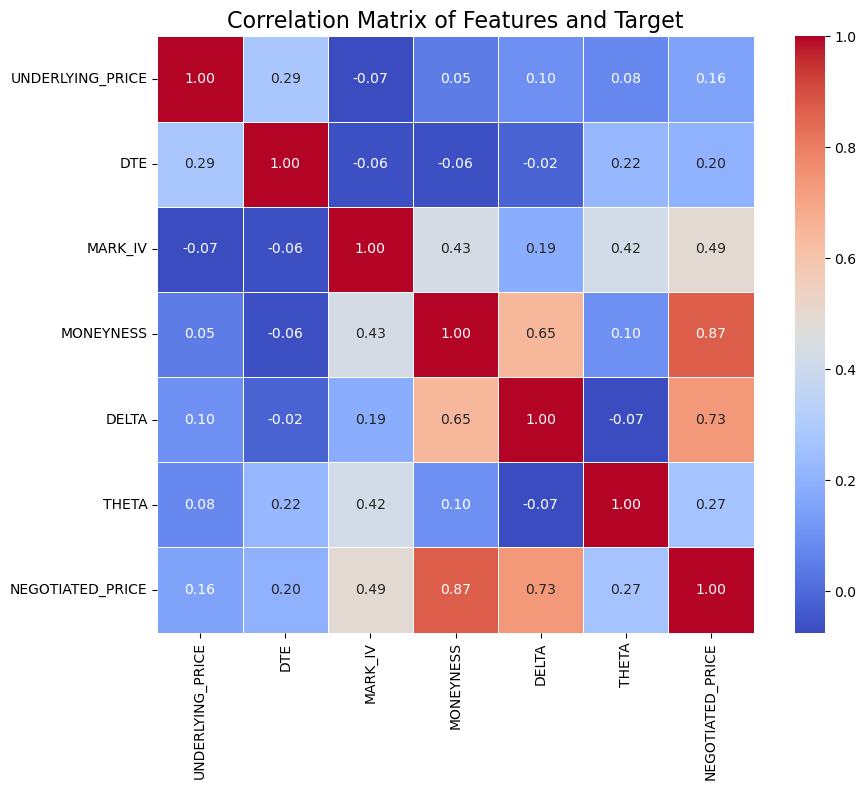

In [4]:
correlation_matrix = train_data[features + [target]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,            
    fmt=".2f",             
    cmap="coolwarm",       
    cbar=True,             
    square=True,           
    linewidths=0.5         
)

plt.title("Correlation Matrix of Features and Target", fontsize=16)
plt.tight_layout()

plt.show()

In [5]:
# ------------------------- XGBoost Model ------------------------- #
# DMatrix is an internal data structure that is used by XGBoost, 
# which is optimized for both memory efficiency and training speed.
# https://stackoverflow.com/questions/70127049/what-is-the-use-of-dmatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Intially, I just use some arbitraty parameters. I just want to see if it yields something reasonable.
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

xgb_model = xgb.train(params, dtrain, num_boost_round=100)

xgb_predictions = xgb_model.predict(dtest)

In [6]:
# Evaluate model f'n (this one comes in handy for the entire code)
def evaluate_model(true, predicted, model_name):
    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    r2 = r2_score(true, predicted)
    percent_error = np.abs((true - predicted) / true) * 100
    pe5 = np.mean(percent_error <= 5) * 100  # Percentage of predictions within 5% error
    pe10 = np.mean(percent_error <= 10) * 100  # Percentage of predictions within 10% error
    pe20 = np.mean(percent_error <= 20) * 100  # Percentage of predictions within 20% error

    
    print(f"\n{model_name} Performance:")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"  R^2: {r2}")
    print(f"  PE5: {pe5:.2f}%")
    print(f"  PE10: {pe10:.2f}%")
    print(f"  PE20: {pe20:.2f}%")

evaluate_model(y_test, xgb_predictions, "XGBoost")


XGBoost Performance:
  MSE: 734437.9709101738
  MAE: 221.66098621293048
  R^2: 0.9938641496402307
  PE5: 56.91%
  PE10: 70.80%
  PE20: 77.84%


In [7]:
# The results were reasonable. Now, I will make some hiperparameter tuning and all of that jazz

param_distributions = {
    'max_depth': [3, 5, 7],          
    'eta': [0.01, 0.1, 0.3],        # Learning rate
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],  
    'n_estimators': [50, 100, 200]  # Number of trees
}

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

# Initialize RandomizedSearchCV (I wish I could do GridSearchCV, but it just takes forever...)
random_search = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_distributions,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    n_iter=50  # Number of random parameter settings sampled
)


random_search.fit(X_train, y_train)

print("\nBest Hyperparameters:", random_search.best_params_)
print("Best Score (MSE):", -random_search.best_score_)

# Model with the best parameters
best_xgb_model = random_search.best_estimator_
xgb_tuned_predictions = best_xgb_model.predict(X_test)

# Evaluate the tuned model
evaluate_model(y_test, xgb_tuned_predictions, "Tuned XGBoost")


Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'eta': 0.3, 'colsample_bytree': 1.0}
Best Score (MSE): 354919.86188252765

Tuned XGBoost Performance:
  MSE: 751516.3042661364
  MAE: 189.14633277591696
  R^2: 0.993721468975536
  PE5: 60.81%
  PE10: 72.79%
  PE20: 81.17%


In [8]:
"""
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'eta': 0.3, 'colsample_bytree': 1.0}
Best Score (MSE): 354919.86188252765

Tuned XGBoost Performance:
  MSE: 751516.3042661364
  MAE: 189.14633277591696
  R^2: 0.993721468975536
  PE5: 60.81%
  PE10: 72.79%
  PE20: 81.17%
"""

# Also check on residuals
residuals = y_test - xgb_tuned_predictions
print("\nResiduals Analysis:")
print("Mean Residual:", residuals.mean())
print("Standard Deviation of Residuals:", residuals.std())


Residuals Analysis:
Mean Residual: 70.92534184148636
Standard Deviation of Residuals: 864.1595287198743


In [9]:
# On researching other ways to optimize the model, I learned about Optuna optimization - which use Bayesian methods
# Here, I test it on this problem, though RandomSearchCV already yieled some good optimizaton.
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'lambda': trial.suggest_float('lambda', 0.01, 10.0),
        'alpha': trial.suggest_float('alpha', 0.01, 10.0),
        'seed': 42
    }
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best Hyperparameters
best_params = study.best_params
print("\nBest Hyperparameters:", best_params)
print("Best MSE from Optuna:", study.best_value)

# Model with the best parameters (just don't want to name it just like the last one)
optuna_xgb_model = xgb.XGBRegressor(**best_params)
optuna_xgb_model.fit(X_train, y_train)

optuna_predictions = optuna_xgb_model.predict(X_test)

evaluate_model(y_test, optuna_predictions, "Final Tuned XGBoost")

# Also check on residuals
residuals = y_test - optuna_predictions
print("\nResiduals Analysis:")
print("Mean Residual:", residuals.mean())
print("Standard Deviation of Residuals:", residuals.std())



[I 2024-12-02 03:35:58,609] A new study created in memory with name: no-name-839f4d90-25e6-454d-aff1-aee73fc7405b
[I 2024-12-02 03:35:58,850] Trial 0 finished with value: 774712.3413993437 and parameters: {'max_depth': 4, 'eta': 0.24091088484475795, 'subsample': 0.7694463040936292, 'colsample_bytree': 0.8406152015960948, 'n_estimators': 142, 'lambda': 0.5232337412795375, 'alpha': 0.06418485306609759}. Best is trial 0 with value: 774712.3413993437.
[I 2024-12-02 03:35:59,479] Trial 1 finished with value: 542873.7127435174 and parameters: {'max_depth': 6, 'eta': 0.22802700708229592, 'subsample': 0.5790238251752124, 'colsample_bytree': 0.6825953535740331, 'n_estimators': 283, 'lambda': 7.094531532658495, 'alpha': 9.82126973366115}. Best is trial 1 with value: 542873.7127435174.
[I 2024-12-02 03:35:59,892] Trial 2 finished with value: 666836.73962212 and parameters: {'max_depth': 4, 'eta': 0.24394901693015597, 'subsample': 0.573124813349349, 'colsample_bytree': 0.9221497519884863, 'n_estim

[I 2024-12-02 03:36:34,711] Trial 25 finished with value: 518382.9674321462 and parameters: {'max_depth': 6, 'eta': 0.09302914177256014, 'subsample': 0.687307488025458, 'colsample_bytree': 0.8808053246114738, 'n_estimators': 134, 'lambda': 2.9300437954201537, 'alpha': 5.885247784431062}. Best is trial 5 with value: 442201.7462169125.
[I 2024-12-02 03:36:37,202] Trial 26 finished with value: 607553.1892193868 and parameters: {'max_depth': 3, 'eta': 0.17879231620588823, 'subsample': 0.7857893623299397, 'colsample_bytree': 0.7039335690055393, 'n_estimators': 152, 'lambda': 6.394238035647243, 'alpha': 4.551922653512531}. Best is trial 5 with value: 442201.7462169125.
[I 2024-12-02 03:36:43,758] Trial 27 finished with value: 641358.9081192599 and parameters: {'max_depth': 7, 'eta': 0.12704895616572368, 'subsample': 0.9425398972626211, 'colsample_bytree': 0.646866550489209, 'n_estimators': 177, 'lambda': 8.64680837609885, 'alpha': 1.3984806253994653}. Best is trial 5 with value: 442201.74621


Best Hyperparameters: {'max_depth': 5, 'eta': 0.045478828545210744, 'subsample': 0.7921864723556753, 'colsample_bytree': 0.8176434636868836, 'n_estimators': 147, 'lambda': 7.355505923608972, 'alpha': 6.282904160333591}
Best MSE from Optuna: 442201.7462169125

Final Tuned XGBoost Performance:
  MSE: 482569.5234253218
  MAE: 265.48936512955123
  R^2: 0.9959683805832459
  PE5: 51.24%
  PE10: 65.17%
  PE20: 75.09%

Residuals Analysis:
Mean Residual: 58.23872931317702
Standard Deviation of Residuals: 692.3591743261017


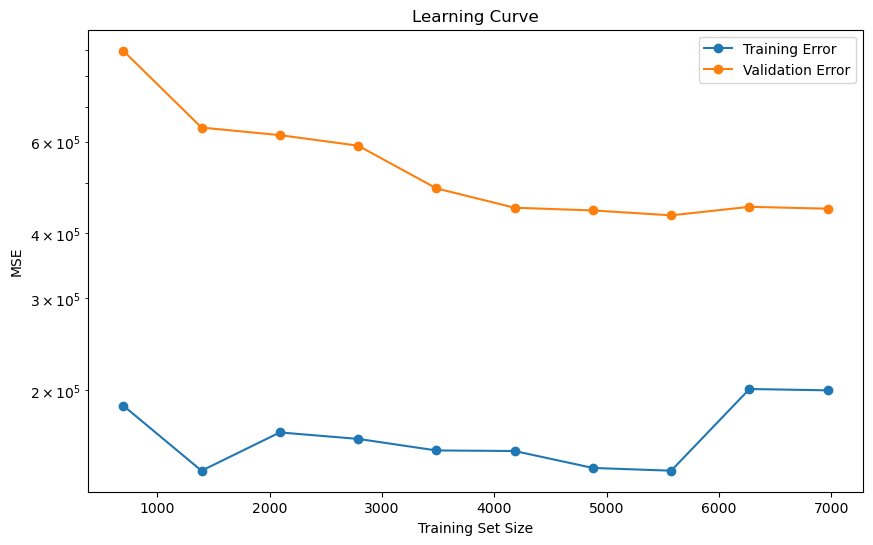

In [10]:
"""
Best Hyperparameters: {'max_depth': 8, 'eta': 0.055139361774463984, 'subsample': 0.5739030326202809, 'colsample_bytree': 0.8883255709596141, 'n_estimators': 149, 'lambda': 6.912603589441515, 'alpha': 9.33439625848375}
Best MSE from Optuna: 358763.9998561388

Final Tuned XGBoost Performance:
  MSE: 381759.55384179606
  MAE: 167.30836707332818
  R^2: 0.9968105958725383
  PE5: 64.75%
  PE10: 77.04%
  PE20: 84.65%

Residuals Analysis:
Mean Residual: 57.227417835949716
Standard Deviation of Residuals: 615.3287566018232
"""

train_sizes, train_scores, valid_scores = learning_curve(
    estimator=optuna_xgb_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Negative MSE to positive RMSE
train_scores_mean = -np.mean(train_scores, axis=1)
valid_scores_mean = -np.mean(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error', marker='o')
plt.plot(train_sizes, valid_scores_mean, label='Validation Error', marker='o')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.yscale("log")
plt.ylabel('MSE')
plt.legend()

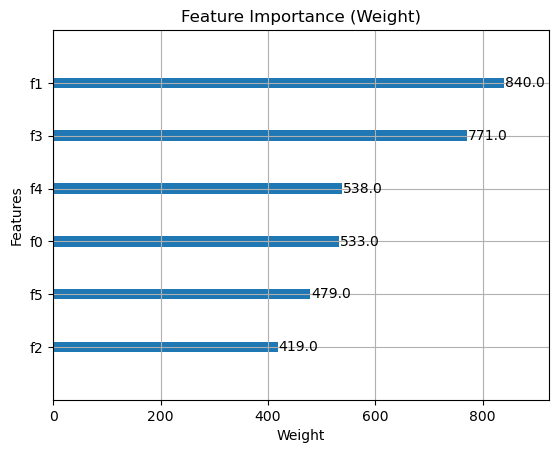

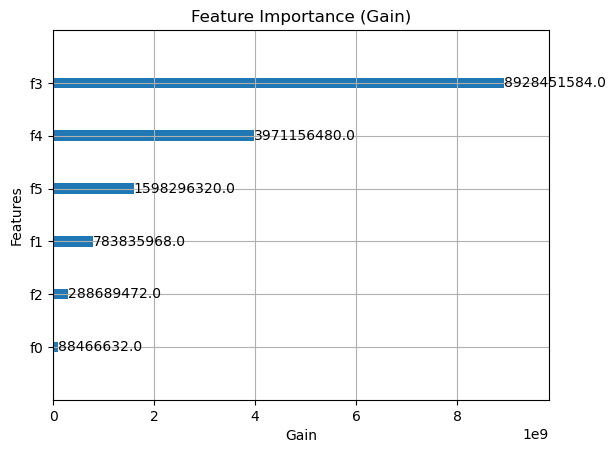

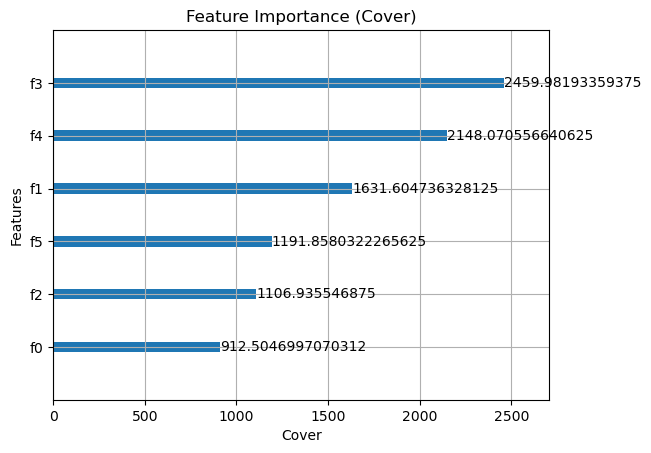

In [11]:
# Though there is a large gap in the beginning, it doesn't seem the data is overfitting (our data is quite large, so I can chill.)
# Also, the premium values are very large, which also justifies the gap in MSE.
# I argue this because the gap diminishes as the training set size increases. I'll still keep it in mind.

# It turns out that the "final" model is actually better than the one optimized with RandomSearchCV
optuna_xgb_model.fit(X_train, y_train)

# feature importance plots
xgb.plot_importance(optuna_xgb_model, importance_type='weight', max_num_features=10, title="Feature Importance (Weight)", xlabel="Weight", ylabel="Features")
plt.show()

xgb.plot_importance(optuna_xgb_model, importance_type='gain', max_num_features=10, title="Feature Importance (Gain)", xlabel="Gain", ylabel="Features")
plt.show()

xgb.plot_importance(optuna_xgb_model, importance_type='cover', max_num_features=10, title="Feature Importance (Cover)", xlabel="Cover", ylabel="Features")
plt.show()


I told you **Moneyness** is important!

In [12]:
# Stratified Split, again.
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# Just being redundant, as I somehow faced a few bugs related to this when running this code
european_calls['MONEYNESS_CATEGORY'] = european_calls['MONEYNESS'].apply(lambda x: 'ITM' if x > 1.05 else 'ATM' if 0.95 <= x <= 1.05 else 'OTM')

for train_idx, test_idx in stratified_split.split(european_calls, european_calls['MONEYNESS_CATEGORY']):
    train_data = european_calls.iloc[train_idx]
    test_data = european_calls.iloc[test_idx]

# Drop the ITM, OTM, ATM strings
train_data = train_data.drop(columns=['MONEYNESS_CATEGORY'])
test_data = test_data.drop(columns=['MONEYNESS_CATEGORY'])

X_train = train_data[features]
X_test = test_data[features]
y_train = train_data[target]
y_test = test_data[target]

# I chose to make a Pipeline this time, because why not?
pca = PCA(n_components=0.95)  # Keep 95% of variance
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', pca)
])

X_train_pca = pipeline.fit_transform(X_train)
X_test_pca = pipeline.transform(X_test)

# Optuna Params
optuna_params = {'max_depth': 8, 'eta': 0.055139361774463984, 'subsample': 0.5739030326202809, 'colsample_bytree': 0.8883255709596141, 'n_estimators': 149, 'lambda': 6.912603589441515, 'alpha': 9.33439625848375}

xgb_model_pca = xgb.XGBRegressor(**optuna_params)



In [13]:
xgb_model_pca.fit(X_train_pca, y_train)

pca_predictions = xgb_model_pca.predict(X_test_pca)

evaluate_model(y_test, pca_predictions, "XGBoost with PCA-Reduced Features")


XGBoost with PCA-Reduced Features Performance:
  MSE: 352851.7481059706
  MAE: 311.1337643125184
  R^2: 0.9970521056762927
  PE5: 45.16%
  PE10: 56.87%
  PE20: 67.28%


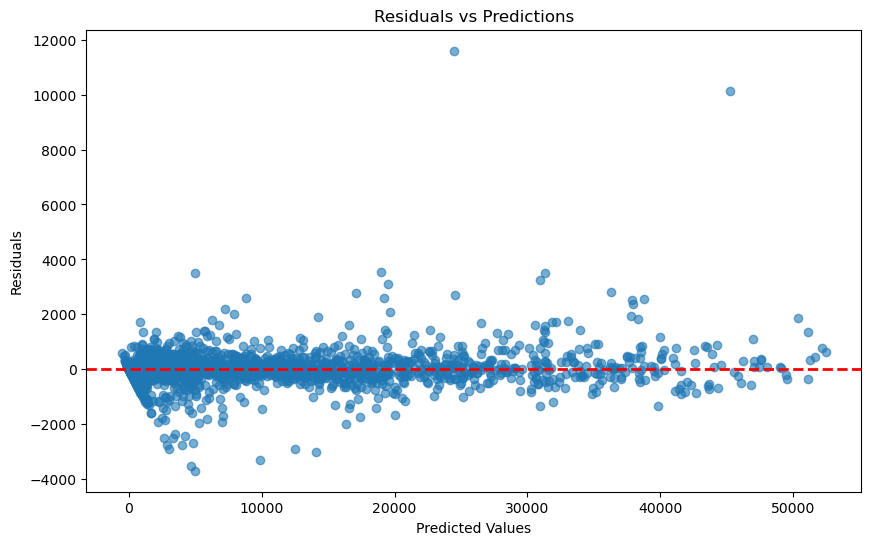

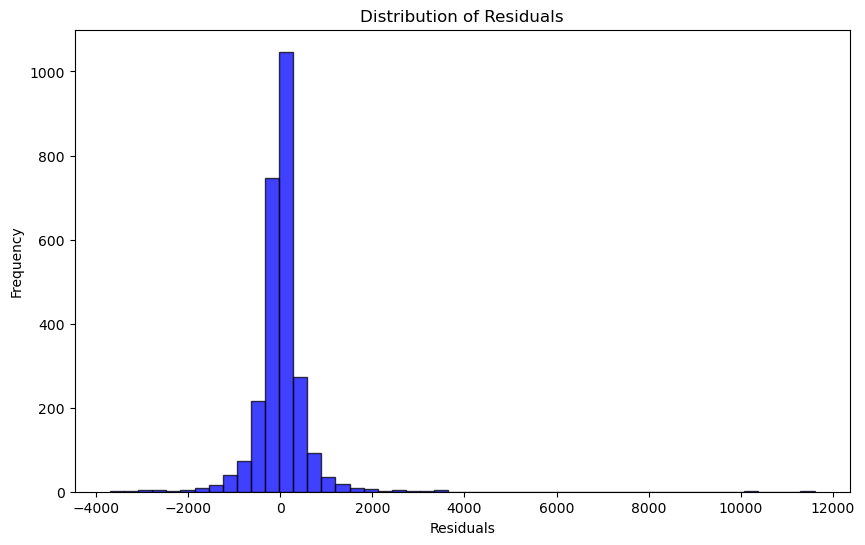

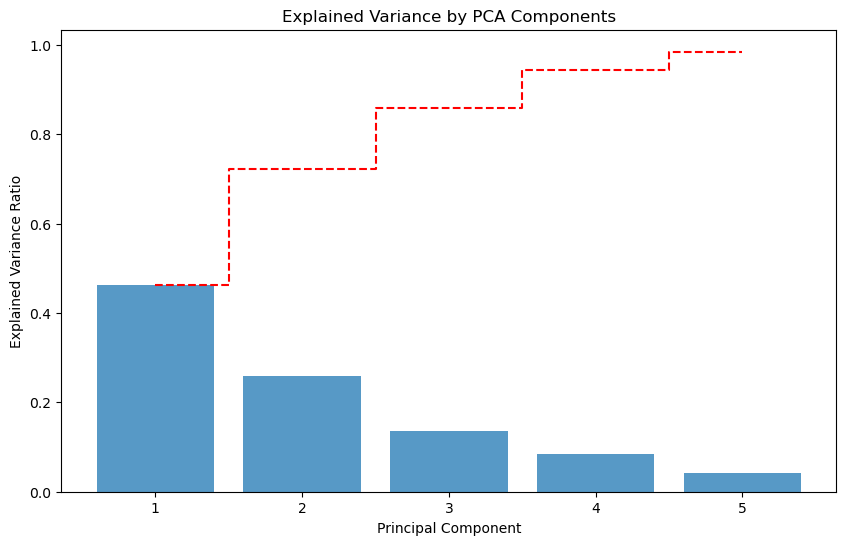

In [14]:
residuals = y_test - pca_predictions

# Residuals v. Predictions scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title("Residuals vs Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Residual Histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Analyze PCA Components Contribution
pca_components = pipeline.named_steps['pca'].components_
explained_variance_ratio = pipeline.named_steps['pca'].explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance by PCA components
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.75, align='center')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', color='red', linestyle='--')
plt.title("Explained Variance by PCA Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()


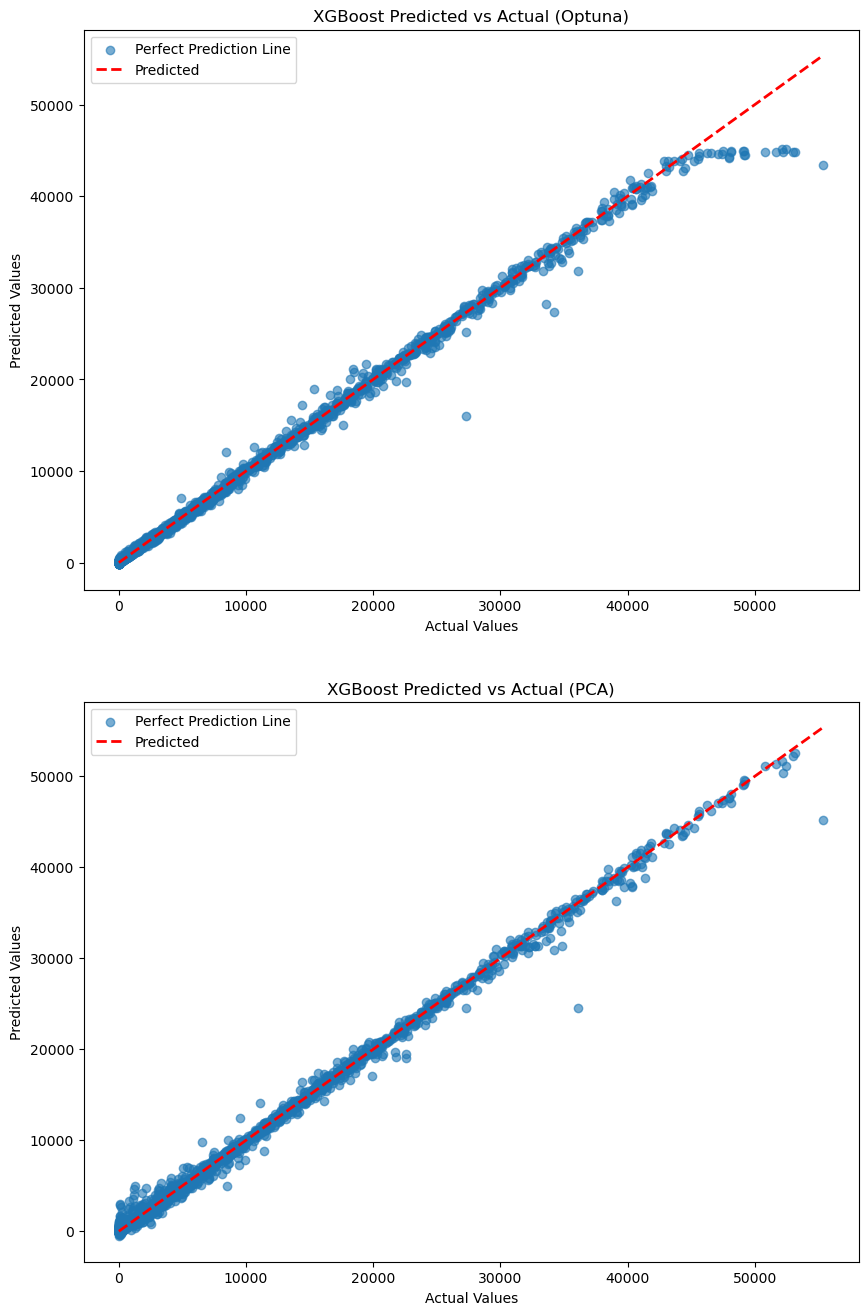

In [15]:
plt.figure(figsize=(10, 16))

plt.subplot(2,1,1)
plt.scatter(y_test, optuna_predictions, alpha=0.6, label="Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction Line")  # Perfect prediction line
plt.title("XGBoost Predicted vs Actual (Optuna)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend(["Perfect Prediction Line", "Predicted"])

plt.subplot(2,1,2)
plt.scatter(y_test, pca_predictions, alpha=0.6, label="Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction Line")  # Perfect prediction line
plt.title("XGBoost Predicted vs Actual (PCA)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend(["Perfect Prediction Line", "Predicted"])
plt.show()


In [16]:
# Optuna is ok, but with PCA is insanely better. Thus, I'll use the latter.
# Segmented Modeling: Separate the data based on MONEYNESS (ITM, ATM, OTM)
# As seen in the Brazilian Options Data, it is crucial to separate the options by Moneyness.
def classify_moneyness(row):
    if row['MONEYNESS'] > 1.05:  # ITM: S/K > 1.05
        return 'ITM'
    elif 0.95 <= row['MONEYNESS'] <= 1.05:  # ATM: 0.95 <= S/K <= 1.05
        return 'ATM'
    else:  # OTM: S/K < 0.95
        return 'OTM'

european_calls['MONEYNESS_CATEGORY'] = european_calls.apply(classify_moneyness, axis=1)
# Add MONEYNESS category to the datasets
train_data['MONEYNESS_CATEGORY'] = train_data.apply(classify_moneyness, axis=1)
test_data['MONEYNESS_CATEGORY'] = test_data.apply(classify_moneyness, axis=1)

# Separate data into segments
train_ITM = train_data[train_data['MONEYNESS_CATEGORY'] == 'ITM']
train_ATM = train_data[train_data['MONEYNESS_CATEGORY'] == 'ATM']
train_OTM = train_data[train_data['MONEYNESS_CATEGORY'] == 'OTM']


test_ITM = test_data[test_data['MONEYNESS_CATEGORY'] == 'ITM']
test_ATM = test_data[test_data['MONEYNESS_CATEGORY'] == 'ATM']
test_OTM = test_data[test_data['MONEYNESS_CATEGORY'] == 'OTM']


# Train separate models for each segment
segment_models = {}
segments = {'ITM': (train_ITM, test_ITM), 'ATM': (train_ATM, test_ATM), 'OTM': (train_OTM, test_OTM)}

for segment, (train_segment, test_segment) in segments.items():
    X_train_segment = train_segment[features]
    y_train_segment = train_segment[target]
    X_test_segment = test_segment[features]
    y_test_segment = test_segment[target]
    
    xgb_model_pca.fit(X_train_segment, y_train_segment)

    segment_models[segment] = {
        'model': xgb_model_pca,
        'X_test': X_test_segment,
        'y_test': y_test_segment,
        'predictions': xgb_model_pca.predict(X_test_segment)

    }

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
# MAPE for each segment
for segment, data in segment_models.items():
    y_test_segment = data['y_test']
    predictions_segment = data['predictions']
    
    evaluate_model(y_test_segment, predictions_segment, f"Segmented Model - {segment}")
    
    mape_segment = mean_absolute_percentage_error(y_test_segment, predictions_segment)
    print(f"MAPE: {mape_segment:.2f}%")




Segmented Model - ITM Performance:
  MSE: 489619.5329854178
  MAE: 276.5693472809017
  R^2: 0.9963027382191352
  PE5: 94.93%
  PE10: 98.38%
  PE20: 99.80%
MAPE: 1.72%

Segmented Model - ATM Performance:
  MSE: 15942.580475126688
  MAE: 66.30272335597108
  R^2: 0.9981070644828784
  PE5: 68.99%
  PE10: 81.80%
  PE20: 90.11%
MAPE: 10.62%

Segmented Model - OTM Performance:
  MSE: 7569.2148594957125
  MAE: 30.182784833697557
  R^2: 0.9983434104538162
  PE5: 56.56%
  PE10: 69.94%
  PE20: 78.15%
MAPE: 15.25%


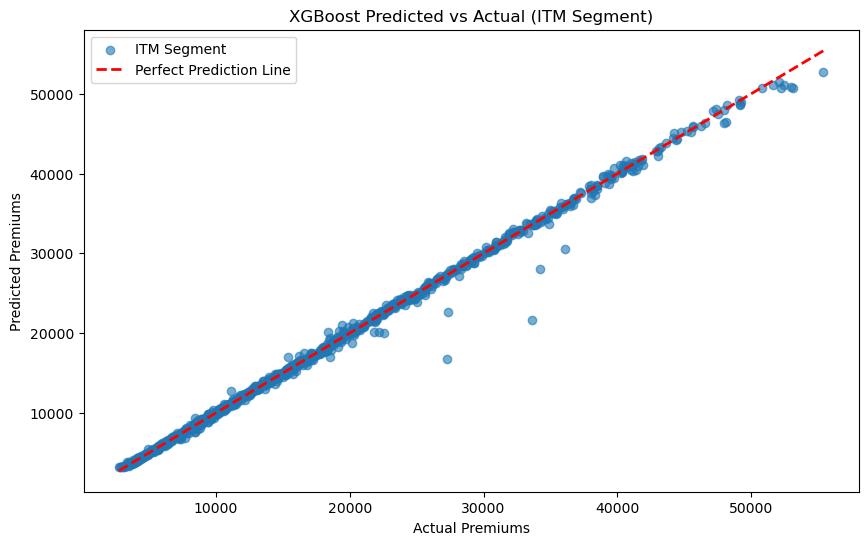

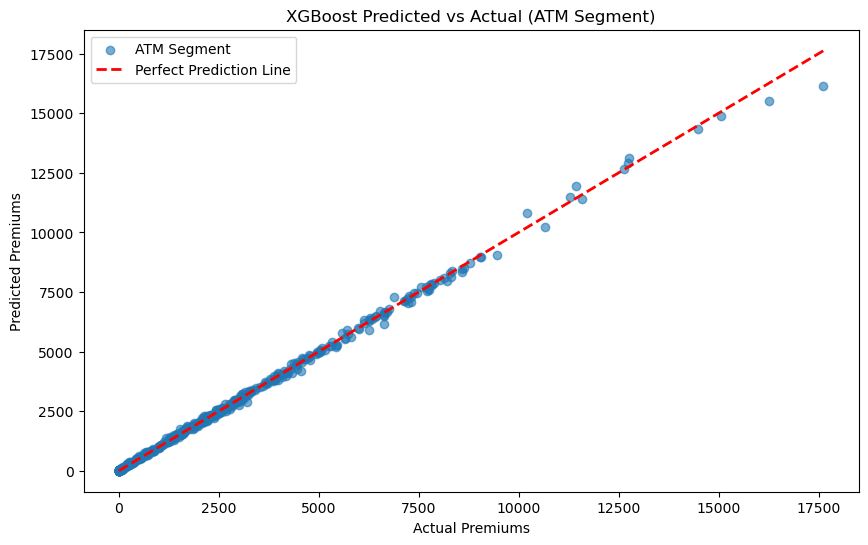

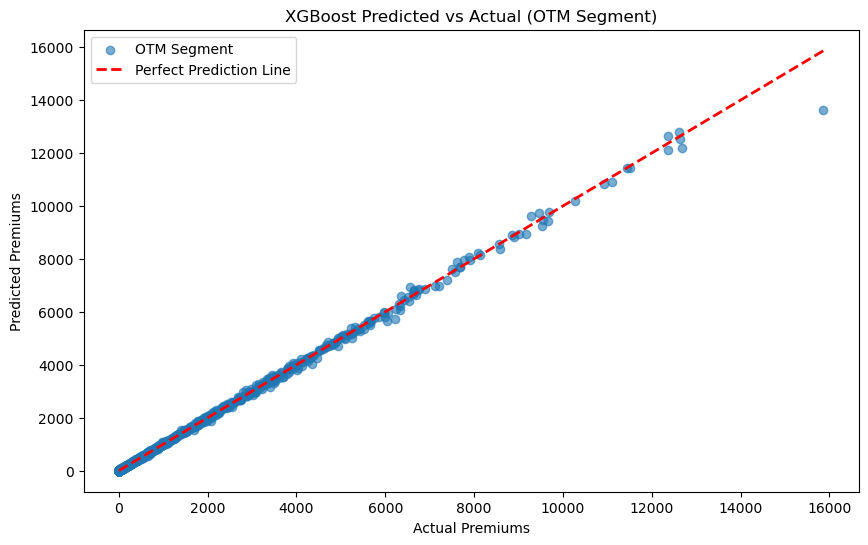

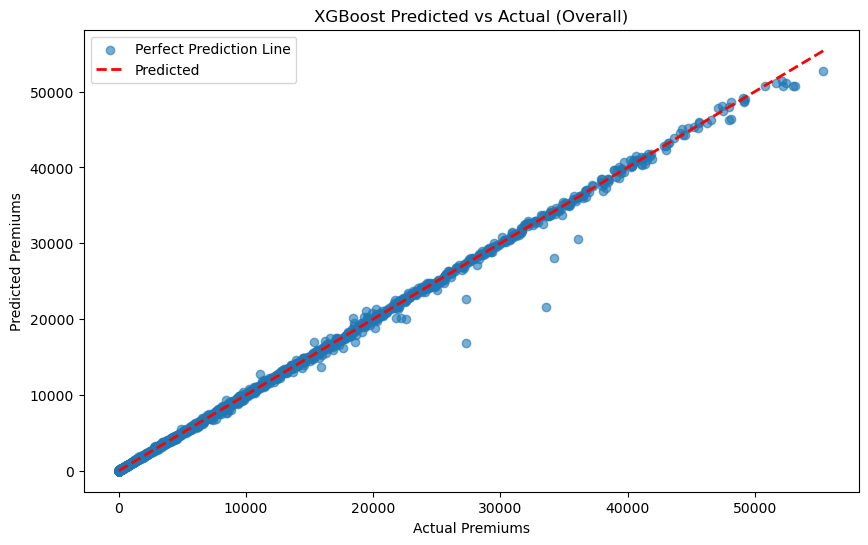

In [18]:
# Predicted vs Actual for each segment
for segment in segments:
    y_test = segment_models[segment]['y_test']
    predictions = segment_models[segment]['predictions']
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.6, label=segment)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Perfect prediction line
    plt.title(f"XGBoost Predicted vs Actual ({segment} Segment)")
    plt.xlabel("Actual Premiums")
    plt.ylabel("Predicted Premiums")
    plt.legend([f'{segment} Segment', 'Perfect Prediction Line'])
    plt.show()

y_test_overall = pd.concat([segment_models[segment]['y_test'] for segment in segments])
predictions_overall = np.concatenate([segment_models[segment]['predictions'] for segment in segments])

# Overall dataset
plt.figure(figsize=(10, 6))
plt.scatter(y_test_overall, predictions_overall, alpha=0.6, label="Predicted")
plt.plot([y_test_overall.min(), y_test_overall.max()], [y_test_overall.min(), y_test_overall.max()], 'r--', lw=2, label="Perfect Prediction Line")  # Perfect prediction line
plt.title("XGBoost Predicted vs Actual (Overall)")
plt.xlabel("Actual Premiums")
plt.ylabel("Predicted Premiums")
plt.legend(["Perfect Prediction Line", "Predicted"])
plt.show()

#### It seems to me that I've exhausted the XGBoost model and I don't see how to run using it alone.
#### Another Idea is, then, to stack two models - namely, the XGBoost with the Random Forest Regressor, I'll try to explore that Later.